In [1]:
#Import libraries

# data preprocessing
import pandas as pd
import numpy as np
import datetime as dt
import math

# data vizualization
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.figure(figsize=(18,16)) # figure size
sns.set_style("darkgrid")

# date and time
from datetime import datetime
from datetime import timedelta
from time import time

# statistic modeling
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL # decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
# pip install pmdarima
import pmdarima as pm
from pmdarima import auto_arima

<Figure size 1296x1152 with 0 Axes>

# Import data

In [2]:
# import data
data = pd.read_excel('Intuit_Craft_Demo_Data_File.xlsx', sheet_name='Data')

In [3]:
# check data
data.head()

,Team,Product,Primary AHT (in mins),Follow-up %,Follow-Up AHT (in mins),2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,...,2022-03-01 00:00:00,2022-04-01 00:00:00,2022-05-01 00:00:00,2022-06-01 00:00:00,2022-07-01 00:00:00,2022-08-01 00:00:00,2022-09-01 00:00:00,2022-10-01 00:00:00,2022-11-01 00:00:00,2022-12-01 00:00:00
0,Underwriting,Payments,12.00,0.15,8.0,4236,3987,4102,4222,4136,...,5369,5698,4896,6039,6356,6536,6007,6600,6578,6832
1,Fraud,Payments,15.00,0.16,8.0,3600,3898,4365,3789,5986,...,5659,5100,5365,6056,10034,6300,6245,6893,6586,6983
2,Transactional Risk,Payments,14.00,NaN,NaN,6235,6132,8564,6354,6489,...,11569,8167,7265,11569,10000,10851,12569,10012,9656,13228
3,Chargebacks,Payments,5.00,NaN,NaN,6123,6000,6369,7236,6656,...,9863,9756,10223,10569,10236,10989,11023,10563,11678,11789
4,Collections,Payments,5.29,NaN,NaN,7695,7789,7896,8569,8632,...,12279,12653,13002,13211,13500,13900,14000,14100,14250,14400


# Data preparation

In [4]:
# unpivot data
data_unpivot = pd.melt(data, id_vars=data.columns.values.tolist()[:5], value_vars=data.columns.values.tolist()[5:])

In [5]:
# rename columns
data_unpivot.rename(columns={"variable": "Year_and_Month", "value": "Primary case_vol."}, inplace=True)

In [6]:
# remove columns -- Primary AHT and Follow-up AHT
# rename dataframe --> df
df = data_unpivot[['Team', 'Product', 'Year_and_Month', 'Primary case_vol.']]

In [7]:
# check
df.head()

,Team,Product,Year_and_Month,Primary case_vol.
0,Underwriting,Payments,2020-01-01,4236
1,Fraud,Payments,2020-01-01,3600
2,Transactional Risk,Payments,2020-01-01,6235
3,Chargebacks,Payments,2020-01-01,6123
4,Collections,Payments,2020-01-01,7695


# Data exploration

In [8]:
# number of rows and columns (row, col)
df.shape

(360, 4)

In [9]:
# data types
df.dtypes

Team                         object
Product                      object
Year_and_Month       datetime64[ns]
Primary case_vol.             int64
dtype: object

In [10]:
# numerical data statistical summary
df.describe()

,Primary case_vol.
count,360.000000
mean,5827.308333
std,3059.554364
min,1023.000000
25%,3640.500000
50%,5236.000000
75%,7780.750000
max,14400.000000


In [11]:
# check missing values
df.isnull().sum()

Team                 0
Product              0
Year_and_Month       0
Primary case_vol.    0
dtype: int64

# Data visualization

In [12]:
# total primary case vol. over time by product
total_primary_case_vol_by_product = df.groupby(by=['Year_and_Month', 'Product']).sum().reset_index()

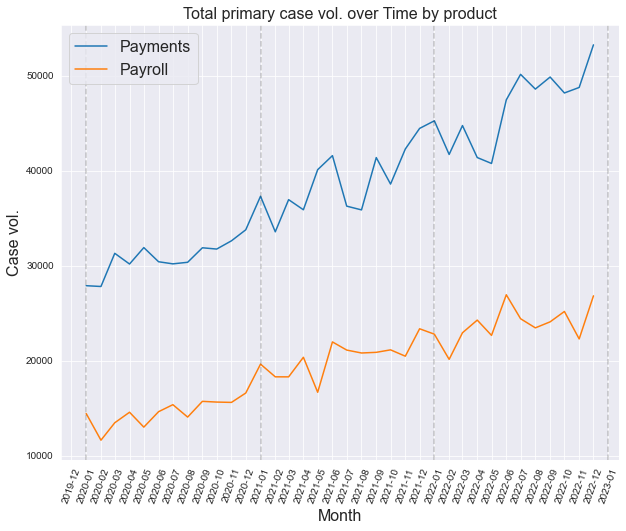

In [13]:
plt.figure(figsize=(10,8))
sns.lineplot(data=total_primary_case_vol_by_product, x='Year_and_Month', y='Primary case_vol.', hue='Product')
plt.xticks(rotation=70)
plt.title('Total primary case vol. over Time by product', fontsize=16)
plt.ylabel('Case vol.', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.legend(loc='upper left', prop={'size': 16})
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

for year in range(2020,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [14]:
# total primary case vol. over time by workflow
total_primary_case_vol_by_workflow = df.groupby(by=['Year_and_Month', 'Team']).sum().reset_index()

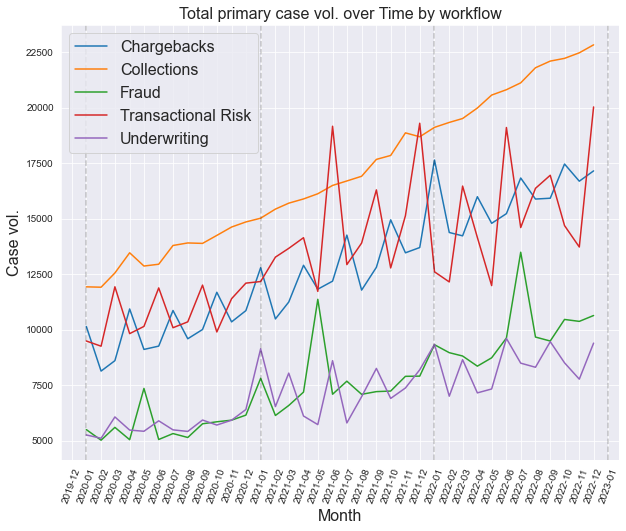

In [15]:
plt.figure(figsize=(10,8))
sns.lineplot(data=total_primary_case_vol_by_workflow, x='Year_and_Month', y='Primary case_vol.', hue='Team')
plt.xticks(rotation=70)
plt.title('Total primary case vol. over Time by workflow', fontsize=16)
plt.ylabel('Case vol.', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.legend(loc='upper left', prop={'size': 16})
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

for year in range(2020,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [16]:
# primary case vol. over time by workflow by product

In [17]:
# define a function to show graph
def show_graph(workflow_name):
    '''This function shows case vol. over time by that workflow by product
       workflow_name: input the workflow name.'
    '''
    
    workflow_data = df.loc[df['Team'] == workflow_name]
    
    plt.figure(figsize=(8,6))
    plt.xticks(rotation=70)
    
    sns.lineplot(data=workflow_data, x='Year_and_Month', y='Primary case_vol.', hue='Product')
    
    plt.title(workflow_name + ': ' + 'primary case vol. over Time by product', fontsize=16)
    plt.ylabel('Case vol.', fontsize=16)
    plt.xlabel('Month', fontsize=16)
    plt.legend(loc='upper left', prop={'size': 16})
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    
    for year in range(2020,2024):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

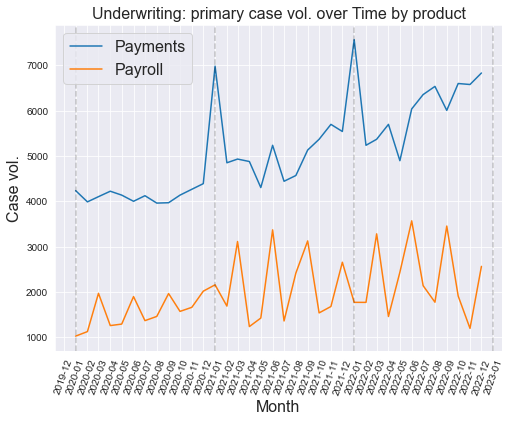

In [18]:
show_graph('Underwriting')

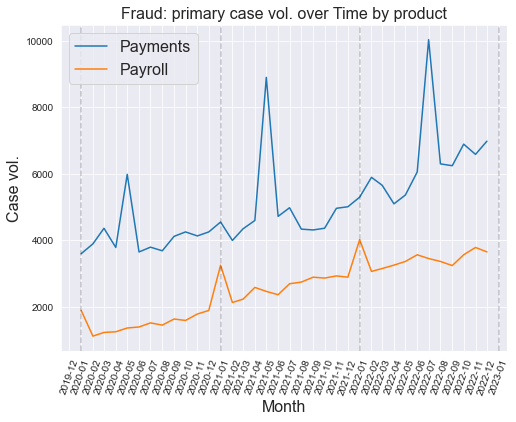

In [19]:
show_graph('Fraud')

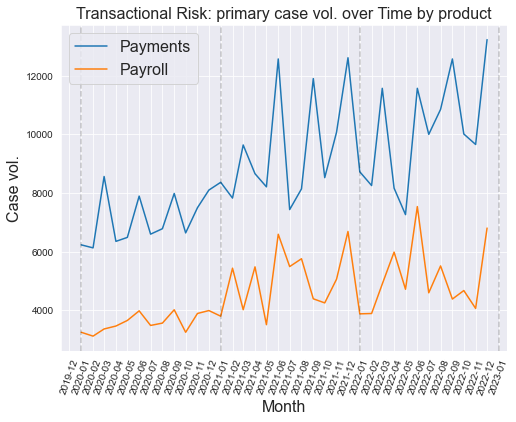

In [20]:
show_graph('Transactional Risk')

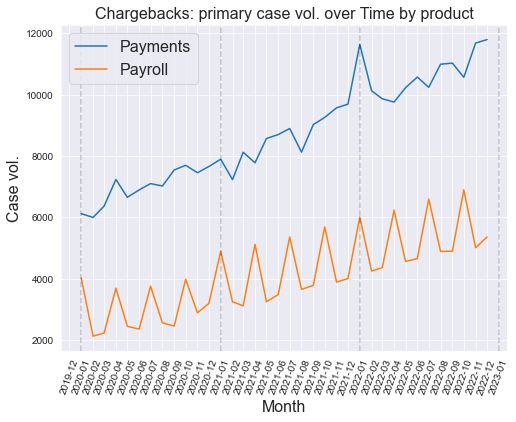

In [21]:
show_graph('Chargebacks')

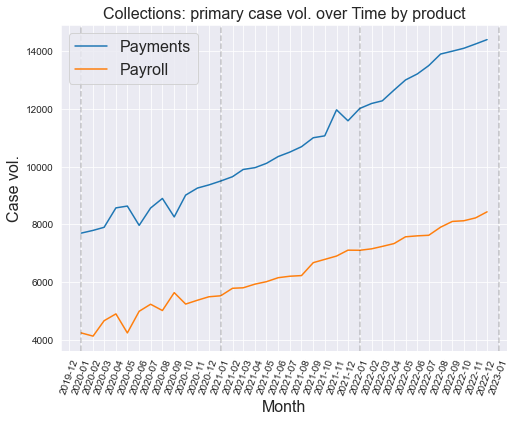

In [22]:
show_graph('Collections')

# Data Pipeline

In [23]:
workflow_lst = ['Underwriting', 'Fraud', 'Transactional Risk', 'Chargebacks', 'Collections']

In [24]:
def data_prep(workflow, product):
    '''This fuction takes workflow and product and return a data frame ready for modeling'''
    
    # slice dataframe
    sub_df = df.loc[(df['Product'] == product) & (df['Team'] == workflow)][['Year_and_Month', 'Primary case_vol.']]
    
    # set index
    sub_df.set_index('Year_and_Month', inplace=True)
    
    #infer the frequency of the data
    sub_df = sub_df.asfreq(pd.infer_freq(sub_df.index))

    print(f'confirm: {workflow}/{product} dataframe ready for using')
    
    return sub_df

In [25]:
def decomposition(df):
    '''This function takes dataframe and return the decompposition plot for time series analysis'''
    
    result = seasonal_decompose(df, model='multiplicative')
    
    result.plot()
    plt.figure(figsize=(40,10))
    plt.show()

In [26]:
def plot_ACF(df):
    '''This function return ACF plot'''
    
    df_acf_plot = plot_acf(df.values, lags=16)

In [27]:
def plot_PACF(df):
    '''This function return ACF plot'''
    
    df_pacf_plot = plot_pacf(df.values, lags=16, method = 'ywm')

In [28]:
def Dicky_Fuller_test(df):
    '''This function test stationarity using Dicky-Fuller Test'''
    
    X = df.values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    p_value = result[1]
    if p_value  > 0.05:
        print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
    else:
        print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')

**Dickey-Fuller Test**
- Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [29]:
def differencing(df, diff_value):
    '''This function takes differencing and trasnforms time series to stationary'''
    
    df_diff = df['Primary case_vol.'].diff(diff_value).dropna()
    
    print(f'confirm: lag-{diff_value} differencing has been taken')
    
    return df_diff

In [30]:
def parameter_selection(train_data, max_p, max_q, max_P, max_Q, m):
    '''This fuction selects best parameters automatically'''
    
    model = auto_arima(train_data, start_p=0, start_q=0,
                          max_p=max_p, max_q=max_q,m=m,start_P=0,start_Q=0, 
                          max_P =max_P, max_Q=max_Q,
                          seasonal=True,
                          d=1,D=1,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

In [31]:
def split_training_and_testing_date(df):
    '''This function split and return training and test datasets'''
    
    train_end = datetime(2022,6,1)
    test_end = datetime(2022,12,1)

    train_data = df[:train_end]
    test_data = df[train_end + timedelta(days=1):test_end]
    
    return train_data, test_data

In [32]:
def fit_model(order_lst, seasonal_lst, train_data):
    '''This function fit and return a SARIMA model'''
    
    # define model
    model = SARIMAX(train_data, order = order_lst, seasonal_order = seasonal_lst)
    
    #fit the mode
    result = model.fit()
    
    return result

In [33]:
def model_summary(model):
    '''This function returns model summary'''
    
    print(model.summary())

    model.plot_diagnostics(figsize=(14,10))
    plt.show()

In [34]:
def model_validation(test_data, model, df, workflow, product):
    '''This function returns preduction over original data and MAPE'''
    
    # get the predictions
    predictions = model.forecast(len(test_data))
    predictions = pd.Series(predictions, index=test_data.index)
    
    # Plot
    plt.figure(figsize=(10,4))

    plt.plot(df)
    plt.plot(predictions)

    plt.xticks(rotation=70)
    plt.legend(('Data', 'Predictions'), fontsize=16)

    plt.title(f'{workflow} {product} primary case vol. over time', fontsize=20)
    plt.ylabel('Case vol.', fontsize=16)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

    for year in range(2020,2024):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
        
    # Compute MAPE (Mean Absolute Percent Error)
    residuals = test_data.squeeze() - predictions
    
    mape = round(np.mean(abs(residuals/test_data.squeeze())),4)
    
    if mape <= 0.1:
        print(f'Mean Absolute Percent Error: {mape} \nconclusion: Very good model (MAPE <= 0.1)')
    elif mape > 0.1 and mape <= 0.2:
        print(f'Mean Absolute Percent Error: {mape} \nconclusion: Good model (0.1 < MAPE <= 0.2)')
    elif mape > 0.2 and mape <= 0.5:
        print(f'Mean Absolute Percent Error: {mape} \nconclusion: OK model (0.2 < MAPE <= 0.5)')
    else: 
        print(f'Mean Absolute Percent Error: {mape} \nconclusion: Not good model (MAPE > 0.5)')

**Mean Absolute Percentage Error (MAPE)** is the mean of all absolute percentage errors between the predicted and actual values.

In [35]:
def forecast_values(model, df, workflow, product):
    '''This function returns predictions'''
    
    forecast_values = model.get_forecast(18)

    print(f'confirm: This is {workflow} ({product}) predictions in 2023')
    return forecast_values

In [36]:
def forecast_plot(model, df, workflow, product):
    '''This function makes predictions and plots forecasting'''
    
    # Make prediction
    forecast_values = model.get_forecast(18)
    forecast_ci = forecast_values.conf_int()

    # plot forecast values
    plt.figure(figsize=(8,6))
    ax = df.plot()
    forecast_values.predicted_mean.plot(ax=ax, label = 'Forecast')

    # Plot confidence intervals
    ax.fill_between(forecast_ci.index,
                    forecast_ci.iloc[:,0],
                   forecast_ci.iloc[:,1],color='g', alpha=.5)

    ax.set_xlabel('Month', fontsize=16)
    ax.set_ylabel('Case vol.', fontsize=16)
    ax.set_title(f'{workflow} ({product}) SARIMA forecasting', fontsize=16)

    plt.legend(loc='upper left', prop={'size': 16})

In [37]:
def final_deliverables(forecast_values, workflow, product):
    '''This function delivers final table, answering question: how many agents needed in 2023'''
    
    # Data preparation
    
    # reset index
    forecast = forecast_values.summary_frame().reset_index()
    # remove index name
    forecast = forecast.rename_axis(None, axis=1)
    # rename columns
    forecast = forecast.rename(columns={"index": "Year_and_Month", "mean": "Primary case_vol."})
    # round case vol. to 0 decimal
    forecast['Primary case_vol.'] = forecast['Primary case_vol.'].apply(lambda x: np.round(x, decimals = 0))
    # slice dataframe
    forecast = forecast.iloc[6:, :2] # the first six months are still in 2022
    
    # add column: follow-up cases vol.
    if workflow == 'Underwriting' and product == 'Payments':
        forecast['Follow-up case_vol.'] = np.round(forecast['Primary case_vol.'] * 0.15, decimals = 0)
    elif workflow == 'Underwriting' and product == 'Payroll':
        forecast['Follow-up case_vol.'] = np.round(forecast['Primary case_vol.'] * 0.135, decimals = 0)
    elif workflow == 'Fraud' and product == 'Payments':
        forecast['Follow-up case_vol.'] = np.round(forecast['Primary case_vol.'] * 0.16, decimals = 0)
    elif workflow == 'Fraud' and product == 'Payroll':
        forecast['Follow-up case_vol.'] = np.round(forecast['Primary case_vol.'] * 0.144, decimals = 0)
    else: pass
    
    # create mapping dictionaries
    primary_aht_payments = {'Underwriting':12, 
                            'Fraud':15,
                            'Transactional Risk':14, 
                            'Chargebacks':5, 
                            'Collections':5.29}
    
    primary_aht_payroll = {'Underwriting':7.2, 
                            'Fraud':9,
                            'Transactional Risk':8.4, 
                            'Chargebacks':3, 
                            'Collections':3.174}
    
    follow_up_aht_payments = {'Underwriting':8, 'Fraud':8}
    follow_up_aht_payroll = {'Underwriting':5.6, 'Fraud':5.6}
    
    # add column: 
    if product == 'Payments':
        forecast['Primary_handle_time'] = forecast['Primary case_vol.'] * primary_aht_payments[workflow]
        forecast['Primary_agents_needed'] = forecast['Primary_handle_time'] / (8*60*21*0.65)
        forecast['Primary_agents_needed'] = forecast['Primary_agents_needed'].apply(lambda x: math.ceil(x)) 

    if product == 'Payroll':
        forecast['Primary_handle_time'] = forecast['Primary case_vol.'] * primary_aht_payroll[workflow]
        forecast['Primary_agents_needed'] = forecast['Primary_handle_time'] / (8*60*21*0.65)
        forecast['Primary_agents_needed'] = forecast['Primary_agents_needed'].apply(lambda x: math.ceil(x)) 
    
    
    if workflow == 'Underwriting' or workflow == 'Fraud':
            if product == 'Payments':
                forecast['Follow-up_handle_time'] = forecast['Follow-up case_vol.'] * follow_up_aht_payments[workflow]
                forecast['Follow-up_agents_needed'] = forecast['Follow-up_handle_time'] / (8*60*21*0.65)
                forecast['Follow-up_agents_needed'] = forecast['Follow-up_agents_needed'].apply(lambda x: math.ceil(x)) 

            if product == 'Payroll':
                forecast['Follow-up_handle_time'] = forecast['Follow-up case_vol.'] * follow_up_aht_payroll[workflow]
                forecast['Follow-up_agents_needed'] = forecast['Follow-up_handle_time'] / (8*60*21*0.65)
                forecast['Follow-up_agents_needed'] = forecast['Follow-up_agents_needed'].apply(lambda x: math.ceil(x)) 
    else: pass
    
    # add column:
    forecast['workflow'] = workflow
    forecast['product'] = product
    
    return forecast

# Underwriting payments

confirm: Underwriting/Payments dataframe ready for using


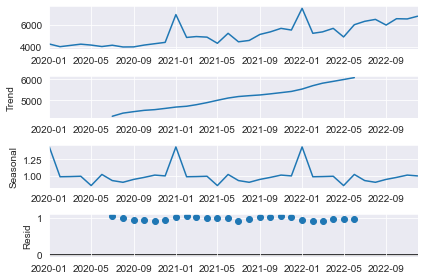

<Figure size 2880x720 with 0 Axes>

ADF Statistic: -2.549921
p-value: 0.103795
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


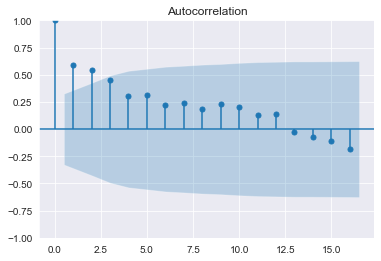

In [38]:
# prepare dataset
un_pm = data_prep('Underwriting', 'Payments')

# decomposition
decomposition(un_pm)

# ACF
plot_ACF(un_pm)

# Dicky_Fuller_test
Dicky_Fuller_test(un_pm)

confirm: lag-1 differencing has been taken
ADF Statistic: -5.771402
p-value: 0.000001
Critical Values:
	1%: -3.738
	5%: -2.992
	10%: -2.636
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


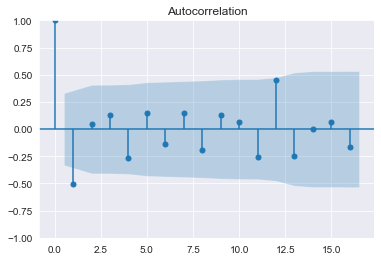

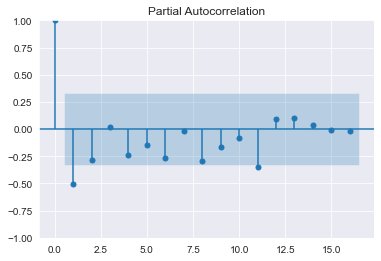

In [39]:
# Take differencing and check stationarity again
un_pm_diff = differencing(un_pm, 1)

# ACF
plot_ACF(un_pm_diff)

# PACF
plot_PACF(un_pm_diff)

# Dicky_Fuller_test
Dicky_Fuller_test(un_pm_diff)

In [40]:
# split data
train_data, test_data = split_training_and_testing_date(un_pm)

# Parameter selection
parameter_selection(train_data, 5, 5, 5, 5, 12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=269.837, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=272.525, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=271.507, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=270.865, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=270.951, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=271.282, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.797 seconds


Mean Absolute Percent Error: 0.0855 
conclusion: Very good model (MAPE <= 0.1)


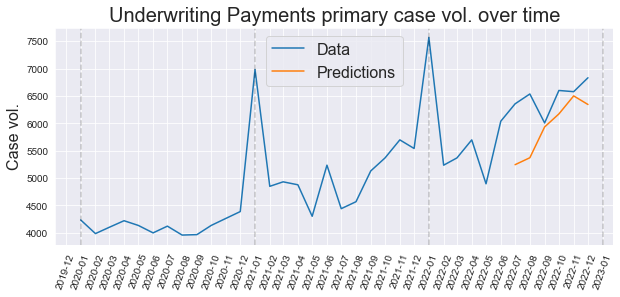

In [41]:
order_lst = [0,1,0]
seasonal_lst = [0,1,0,12]

# fit model
model = fit_model(order_lst, seasonal_lst, train_data)

# model validation
model_validation(test_data, model, un_pm, 'Underwriting', 'Payments')

                                     SARIMAX Results                                      
Dep. Variable:                  Primary case_vol.   No. Observations:                   30
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -133.919
Date:                            Wed, 01 Mar 2023   AIC                            269.837
Time:                                    07:31:56   BIC                            270.670
Sample:                                01-01-2020   HQIC                           269.920
                                     - 06-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.064e+05    9.5e+04      4.277      0.000     2.2e+05    5.93e+05
Ljung-Box (L1) (Q):                

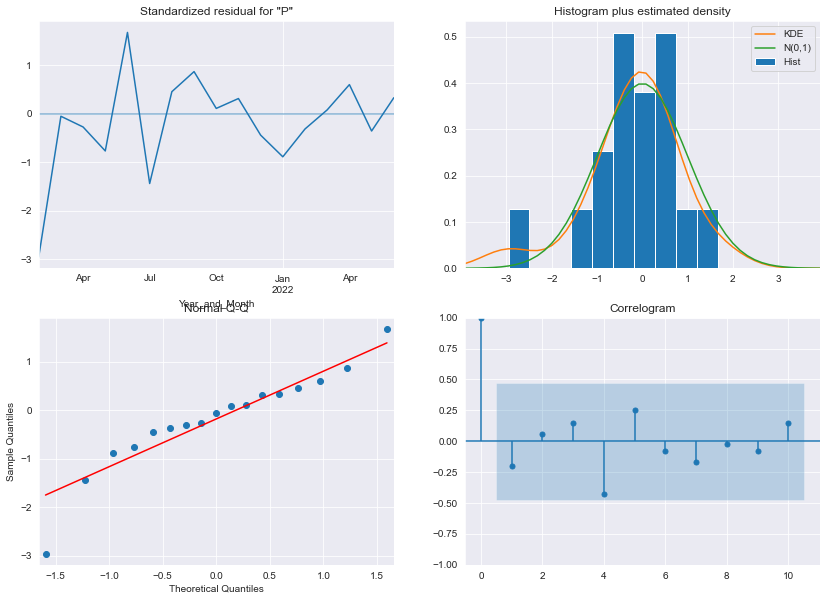

In [42]:
# model summary
model_summary(model)

confirm: This is Underwriting (Payments) predictions in 2023


<Figure size 576x432 with 0 Axes>

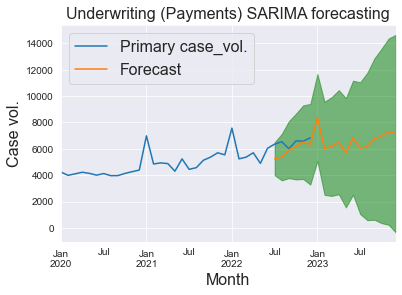

In [43]:
# forecast
forecast = forecast_values(model, un_pm, 'Underwriting', 'Payments')
forecast_plot(model, un_pm, 'Underwriting', 'Payments')

In [44]:
un_pm_final = final_deliverables(forecast, 'Underwriting', 'Payments')
un_pm_final

,Year_and_Month,Primary case_vol.,Follow-up case_vol.,Primary_handle_time,Primary_agents_needed,Follow-up_handle_time,Follow-up_agents_needed,workflow,product
6,2023-01-01,8372.0,1256.0,100464.0,16,10048.0,2,Underwriting,Payments
7,2023-02-01,6039.0,906.0,72468.0,12,7248.0,2,Underwriting,Payments
8,2023-03-01,6172.0,926.0,74064.0,12,7408.0,2,Underwriting,Payments
9,2023-04-01,6501.0,975.0,78012.0,12,7800.0,2,Underwriting,Payments
10,2023-05-01,5699.0,855.0,68388.0,11,6840.0,2,Underwriting,Payments
11,2023-06-01,6842.0,1026.0,82104.0,13,8208.0,2,Underwriting,Payments
12,2023-07-01,6048.0,907.0,72576.0,12,7256.0,2,Underwriting,Payments
13,2023-08-01,6175.0,926.0,74100.0,12,7408.0,2,Underwriting,Payments
14,2023-09-01,6737.0,1011.0,80844.0,13,8088.0,2,Underwriting,Payments
15,2023-10-01,6975.0,1046.0,83700.0,13,8368.0,2,Underwriting,Payments


****

# Underwriting payroll

confirm: Underwriting/Payroll dataframe ready for using


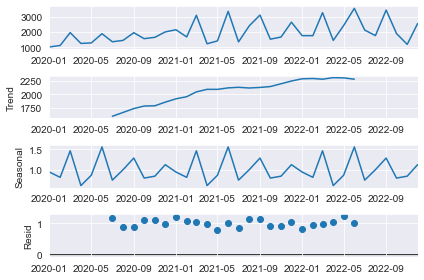

<Figure size 2880x720 with 0 Axes>

ADF Statistic: -1.909254
p-value: 0.327720
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


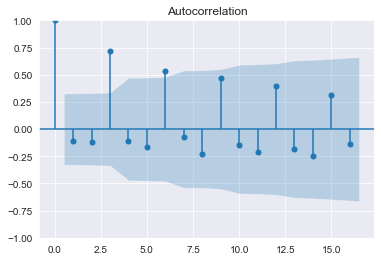

In [45]:
# prepare dataset
un_pr = data_prep('Underwriting', 'Payroll')

# decomposition
decomposition(un_pr)

# ACF
plot_ACF(un_pr)

# Dicky_Fuller_test
Dicky_Fuller_test(un_pr)

confirm: lag-1 differencing has been taken
ADF Statistic: -17.681937
p-value: 0.000000
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


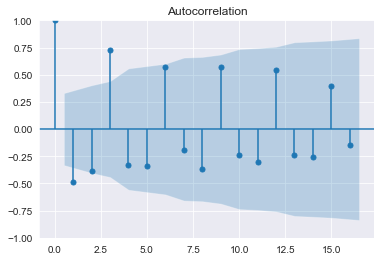

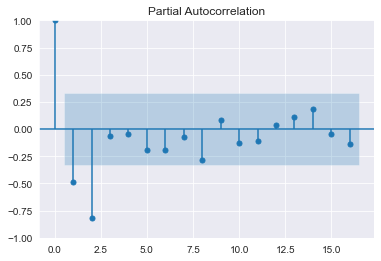

In [46]:
# Take differencing and check stationarity again
un_pr_diff = differencing(un_pr, 1)

# ACF
plot_ACF(un_pr_diff)

# PACF
plot_PACF(un_pr_diff)

# Dicky_Fuller_test
Dicky_Fuller_test(un_pr_diff)

In [47]:
# split data
train_data, test_data = split_training_and_testing_date(un_pr)

# Parameter selection
parameter_selection(train_data, 5, 5, 5, 5, 12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=278.296, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=276.422, Time=0.61 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=271.872, Time=0.21 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=269.908, Time=0.10 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=271.874, Time=0.21 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=271.330, Time=0.19 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=271.224, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=274.444, Time=0.02 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 1.875 seconds


Mean Absolute Percent Error: 0.2814 
conclusion: OK model (0.2 < MAPE <= 0.5)


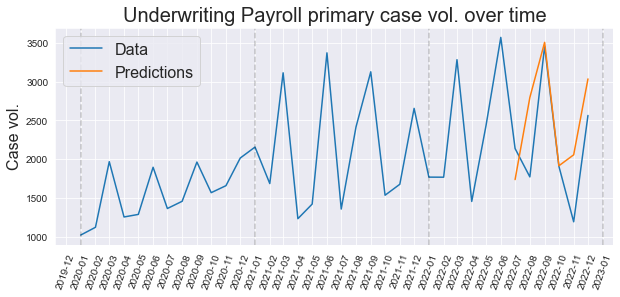

In [48]:
order_lst = [0,1,1]
seasonal_lst = [0,1,0,12]

# fit model
model = fit_model(order_lst, seasonal_lst, train_data)

# model validation
model_validation(test_data, model, un_pr, 'Underwriting', 'Payroll')

                                      SARIMAX Results                                      
Dep. Variable:                   Primary case_vol.   No. Observations:                   30
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -132.954
Date:                             Wed, 01 Mar 2023   AIC                            269.908
Time:                                     07:32:02   BIC                            271.574
Sample:                                 01-01-2020   HQIC                           270.073
                                      - 06-01-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8364      0.240     -3.489      0.000      -1.306      -0.367
sigma2      3.355e+05   1.9

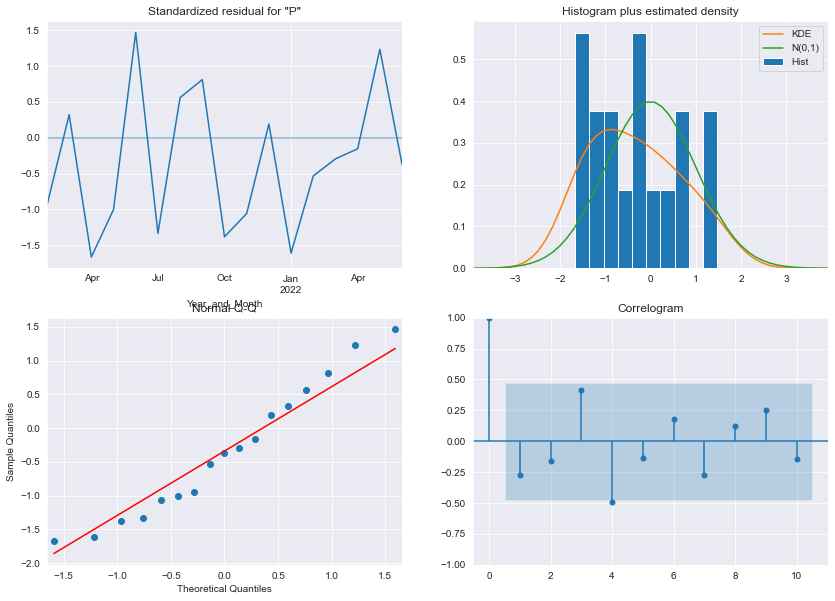

In [49]:
# model summary
model_summary(model)

confirm: This is Underwriting (Payroll) predictions in 2023


<Figure size 576x432 with 0 Axes>

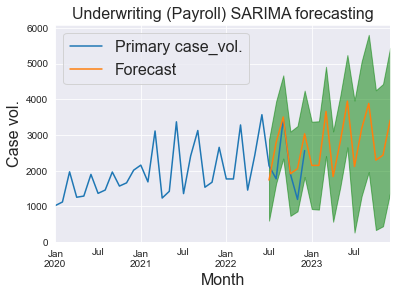

In [50]:
# forecast
forecast = forecast_values(model, un_pr, 'Underwriting', 'Payroll')
forecast_plot(model, un_pr, 'Underwriting', 'Payroll')

In [51]:
un_pr_final = final_deliverables(forecast, 'Underwriting', 'Payroll')
un_pr_final

,Year_and_Month,Primary case_vol.,Follow-up case_vol.,Primary_handle_time,Primary_agents_needed,Follow-up_handle_time,Follow-up_agents_needed,workflow,product
6,2023-01-01,2148.0,290.0,15465.6,3,1624.0,1,Underwriting,Payroll
7,2023-02-01,2147.0,290.0,15458.4,3,1624.0,1,Underwriting,Payroll
8,2023-03-01,3660.0,494.0,26352.0,5,2766.4,1,Underwriting,Payroll
9,2023-04-01,1835.0,248.0,13212.0,3,1388.8,1,Underwriting,Payroll
10,2023-05-01,2813.0,380.0,20253.6,4,2128.0,1,Underwriting,Payroll
11,2023-06-01,3947.0,533.0,28418.4,5,2984.8,1,Underwriting,Payroll
12,2023-07-01,2116.0,286.0,15235.2,3,1601.6,1,Underwriting,Payroll
13,2023-08-01,3173.0,428.0,22845.6,4,2396.8,1,Underwriting,Payroll
14,2023-09-01,3883.0,524.0,27957.6,5,2934.4,1,Underwriting,Payroll
15,2023-10-01,2294.0,310.0,16516.8,3,1736.0,1,Underwriting,Payroll


****

# Fraud payments

confirm: Fraud/Payments dataframe ready for using


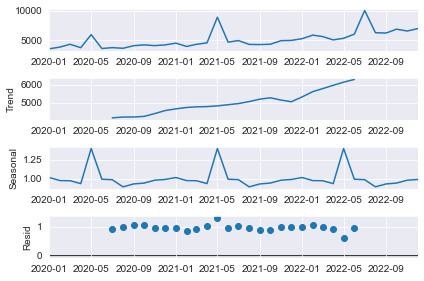

<Figure size 2880x720 with 0 Axes>

ADF Statistic: -3.603650
p-value: 0.005692
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


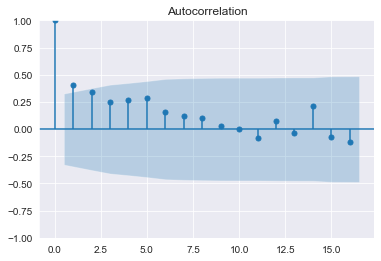

In [52]:
# prepare dataset
fr_pm = data_prep('Fraud', 'Payments')

# decomposition
decomposition(fr_pm)

# ACF
plot_ACF(fr_pm)

# Dicky_Fuller_test
Dicky_Fuller_test(fr_pm)

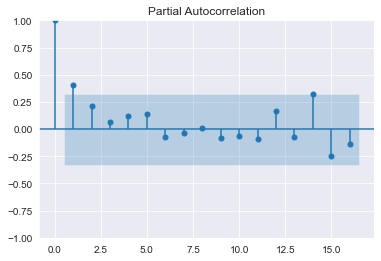

In [53]:
# PACF
plot_PACF(fr_pm)

In [54]:
# split data
train_data, test_data = split_training_and_testing_date(fr_pm)

# Parameter selection
parameter_selection(train_data, 5, 5, 5, 5, 12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=304.306, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=301.257, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=303.094, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=294.356, Time=0.54 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.38 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=2.17 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=294.370, Time=0.61 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(

/Users/mengfanying/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/Users/mengfanying/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Mean Absolute Percent Error: 0.2348 
conclusion: OK model (0.2 < MAPE <= 0.5)


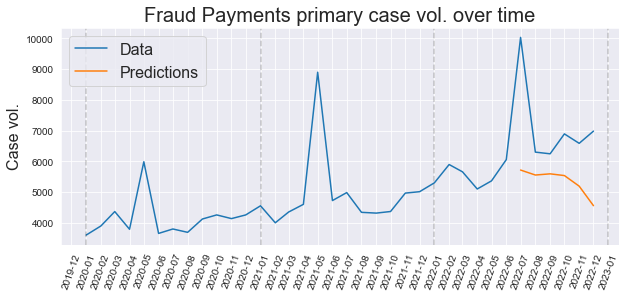

In [55]:
order_lst = [1,1,1]
seasonal_lst = [2,1,1,12] # manually fit

# fit model
model = fit_model(order_lst, seasonal_lst, train_data)

# model validation
model_validation(test_data, model, fr_pm, 'Fraud', 'Payments')

                                     SARIMAX Results                                      
Dep. Variable:                  Primary case_vol.   No. Observations:                   30
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -140.505
Date:                            Wed, 01 Mar 2023   AIC                            293.010
Time:                                    07:32:43   BIC                            298.010
Sample:                                01-01-2020   HQIC                           293.507
                                     - 06-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0930      0.475      0.196      0.845      -0.837       1.024
ma.L1         -0.9766      2.696   

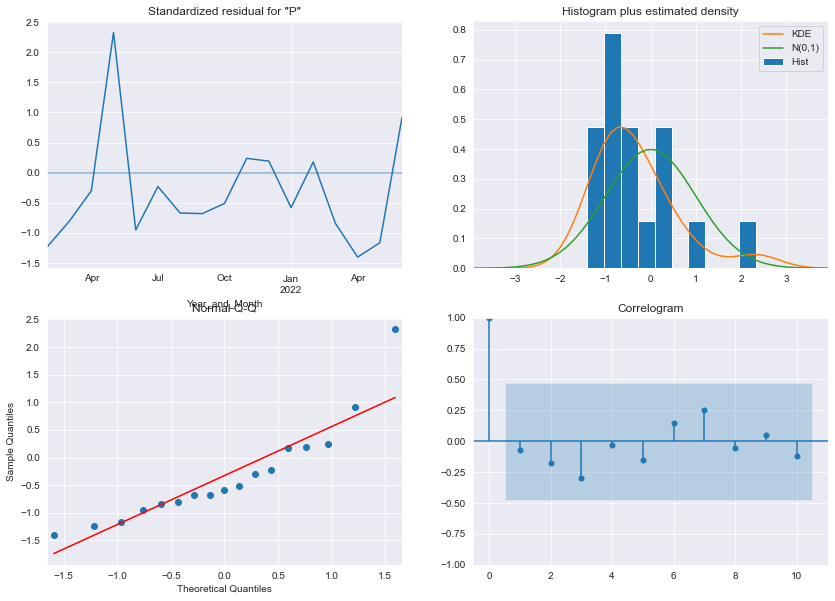

In [56]:
# model summary
model_summary(model)

confirm: This is Fraud (Payments) predictions in 2023


<Figure size 576x432 with 0 Axes>

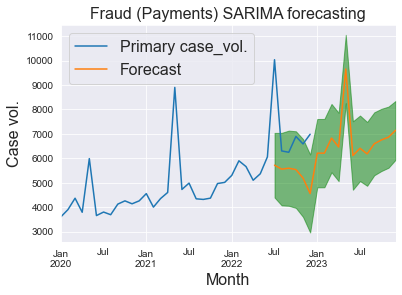

In [57]:
# forecast
forecast = forecast_values(model, fr_pm, 'Fraud', 'Payments')
forecast_plot(model, fr_pm, 'Fraud', 'Payments')

In [58]:
fr_pm_final = final_deliverables(forecast, 'Fraud', 'Payments')
fr_pm_final

,Year_and_Month,Primary case_vol.,Follow-up case_vol.,Primary_handle_time,Primary_agents_needed,Follow-up_handle_time,Follow-up_agents_needed,workflow,product
6,2023-01-01,6208.0,993.0,93120.0,15,7944.0,2,Fraud,Payments
7,2023-02-01,6210.0,994.0,93150.0,15,7952.0,2,Fraud,Payments
8,2023-03-01,6825.0,1092.0,102375.0,16,8736.0,2,Fraud,Payments
9,2023-04-01,6461.0,1034.0,96915.0,15,8272.0,2,Fraud,Payments
10,2023-05-01,9653.0,1544.0,144795.0,23,12352.0,2,Fraud,Payments
11,2023-06-01,6112.0,978.0,91680.0,14,7824.0,2,Fraud,Payments
12,2023-07-01,6408.0,1025.0,96120.0,15,8200.0,2,Fraud,Payments
13,2023-08-01,6179.0,989.0,92685.0,15,7912.0,2,Fraud,Payments
14,2023-09-01,6592.0,1055.0,98880.0,16,8440.0,2,Fraud,Payments
15,2023-10-01,6750.0,1080.0,101250.0,16,8640.0,2,Fraud,Payments


****

# Fraud payroll

confirm: Fraud/Payroll dataframe ready for using


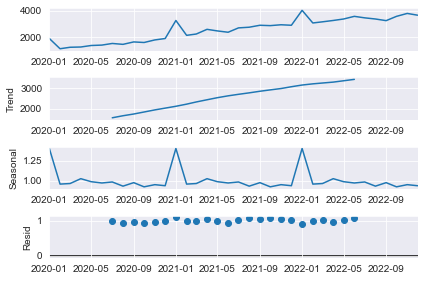

<Figure size 2880x720 with 0 Axes>

ADF Statistic: -0.928466
p-value: 0.778454
Critical Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


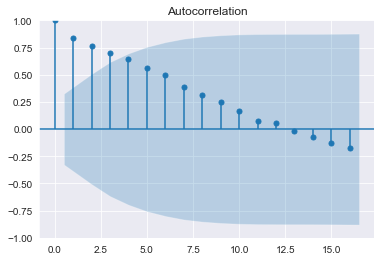

In [59]:
# prepare dataset
fr_pr = data_prep('Fraud', 'Payroll')

# decomposition
decomposition(fr_pr)

# ACF
plot_ACF(fr_pr)

# Dicky_Fuller_test
Dicky_Fuller_test(fr_pr)

confirm: lag-1 differencing has been taken
ADF Statistic: -4.130698
p-value: 0.000861
Critical Values:
	1%: -3.738
	5%: -2.992
	10%: -2.636
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


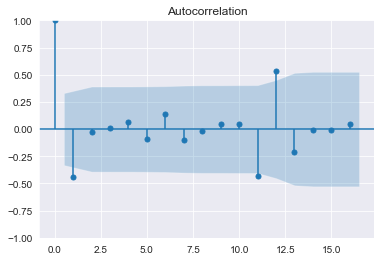

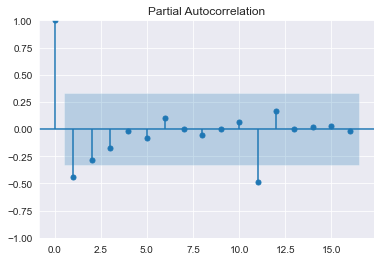

In [60]:
# Take differencing and check stationarity again
fr_pr_diff = differencing(fr_pr, 1)

# ACF
plot_ACF(fr_pr_diff)

# PACF
plot_PACF(fr_pr_diff)

# Dicky_Fuller_test
Dicky_Fuller_test(fr_pr_diff)

In [61]:
# split data
train_data, test_data = split_training_and_testing_date(fr_pr)

# Parameter selection
parameter_selection(train_data, 5, 5, 5, 5, 12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=230.516, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=227.552, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=232.439, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=229.551, Time=0.19 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=225.555, Time=0.05 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=227.558, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=227.480, Time=0.13 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=0.15 sec

Mean Absolute Percent Error: 0.1 
conclusion: Very good model (MAPE <= 0.1)


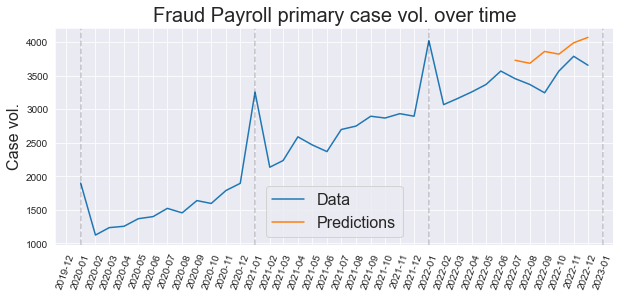

In [62]:
order_lst = [0,1,0]
seasonal_lst = [1,1,0,12]

# fit model
model = fit_model(order_lst, seasonal_lst, train_data)

# model validation
model_validation(test_data, model, fr_pr, 'Fraud', 'Payroll')

                                     SARIMAX Results                                      
Dep. Variable:                  Primary case_vol.   No. Observations:                   30
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -110.777
Date:                            Wed, 01 Mar 2023   AIC                            225.555
Time:                                    07:32:50   BIC                            227.221
Sample:                                01-01-2020   HQIC                           225.721
                                     - 06-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.8153      0.188     -4.327      0.000      -1.185      -0.446
sigma2      1.222e+04   9696.049   

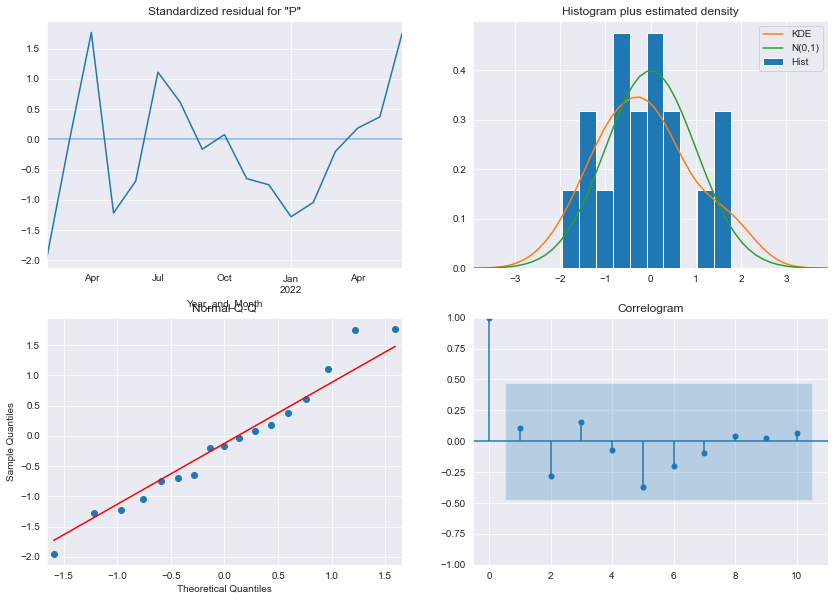

In [63]:
# model summary
model_summary(model)

confirm: This is Fraud (Payroll) predictions in 2023


<Figure size 576x432 with 0 Axes>

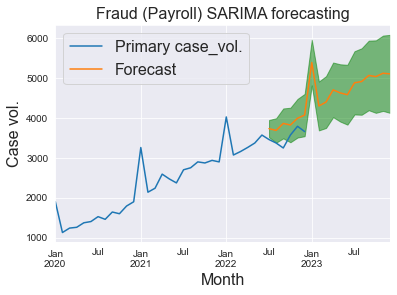

In [64]:
# forecast
forecast = forecast_values(model, fr_pr, 'Fraud', 'Payroll')
forecast_plot(model, fr_pr, 'Fraud', 'Payroll')

In [65]:
fr_pr_final = final_deliverables(forecast, 'Fraud', 'Payroll')
fr_pr_final

,Year_and_Month,Primary case_vol.,Follow-up case_vol.,Primary_handle_time,Primary_agents_needed,Follow-up_handle_time,Follow-up_agents_needed,workflow,product
6,2023-01-01,5388.0,776.0,48492.0,8,4345.6,1,Fraud,Payroll
7,2023-02-01,4298.0,619.0,38682.0,6,3466.4,1,Fraud,Payroll
8,2023-03-01,4396.0,633.0,39564.0,7,3544.8,1,Fraud,Payroll
9,2023-04-01,4703.0,677.0,42327.0,7,3791.2,1,Fraud,Payroll
10,2023-05-01,4625.0,666.0,41625.0,7,3729.6,1,Fraud,Payroll
11,2023-06-01,4581.0,660.0,41229.0,7,3696.0,1,Fraud,Payroll
12,2023-07-01,4879.0,703.0,43911.0,7,3936.8,1,Fraud,Payroll
13,2023-08-01,4912.0,707.0,44208.0,7,3959.2,1,Fraud,Payroll
14,2023-09-01,5064.0,729.0,45576.0,7,4082.4,1,Fraud,Payroll
15,2023-10-01,5035.0,725.0,45315.0,7,4060.0,1,Fraud,Payroll


# Transactional Risk payments

confirm: Transactional Risk/Payments dataframe ready for using


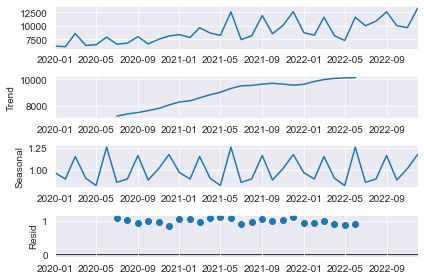

<Figure size 2880x720 with 0 Axes>

ADF Statistic: -0.633461
p-value: 0.863241
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


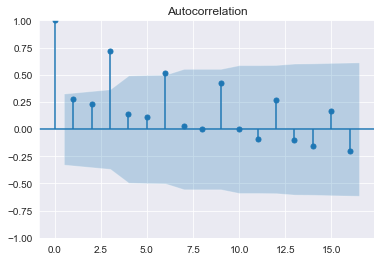

In [66]:
# prepare dataset
tr_pm = data_prep('Transactional Risk', 'Payments')

# decomposition
decomposition(tr_pm)

# ACF
plot_ACF(tr_pm)

# Dicky_Fuller_test
Dicky_Fuller_test(tr_pm)

confirm: lag-1 differencing has been taken
ADF Statistic: -15.913255
p-value: 0.000000
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


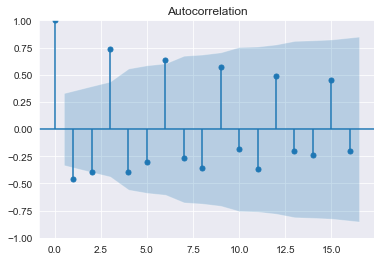

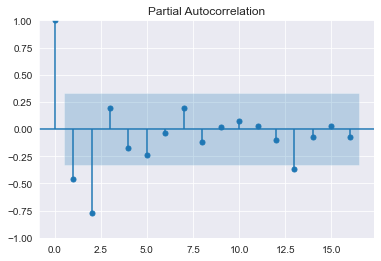

In [67]:
# Take differencing and check stationarity again
tr_pm_diff = differencing(tr_pm, 1)

# ACF
plot_ACF(tr_pm_diff)

# PACF
plot_PACF(tr_pm_diff)

# Dicky_Fuller_test
Dicky_Fuller_test(tr_pm_diff)

In [68]:
# split data
train_data, test_data = split_training_and_testing_date(tr_pm)

# Parameter selection
parameter_selection(train_data, 5, 5, 5, 5, 12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=308.319, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=306.248, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=305.482, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=305.715, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=307.431, Time=0.42 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=305.697, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=307.485, Time=0.03 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=307.482, Time=0.12 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=307.482, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=306.315, Time=0.08 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=309.481, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]        

Mean Absolute Percent Error: 0.1688 
conclusion: Good model (0.1 < MAPE <= 0.2)


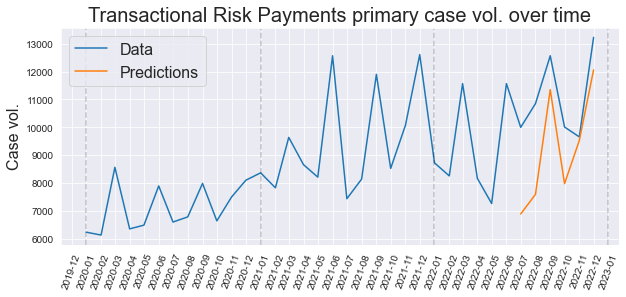

In [69]:
order_lst = [0,1,1]
seasonal_lst = [0,1,0,12]

# fit model
model = fit_model(order_lst, seasonal_lst, train_data)

# model validation
model_validation(test_data, model, tr_pm, 'Transactional Risk', 'Payments')

                                      SARIMAX Results                                      
Dep. Variable:                   Primary case_vol.   No. Observations:                   30
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -150.857
Date:                             Wed, 01 Mar 2023   AIC                            305.715
Time:                                     07:32:58   BIC                            307.381
Sample:                                 01-01-2020   HQIC                           305.880
                                      - 06-01-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5254      0.264     -1.989      0.047      -1.043      -0.008
sigma2      2.768e+06   1.6

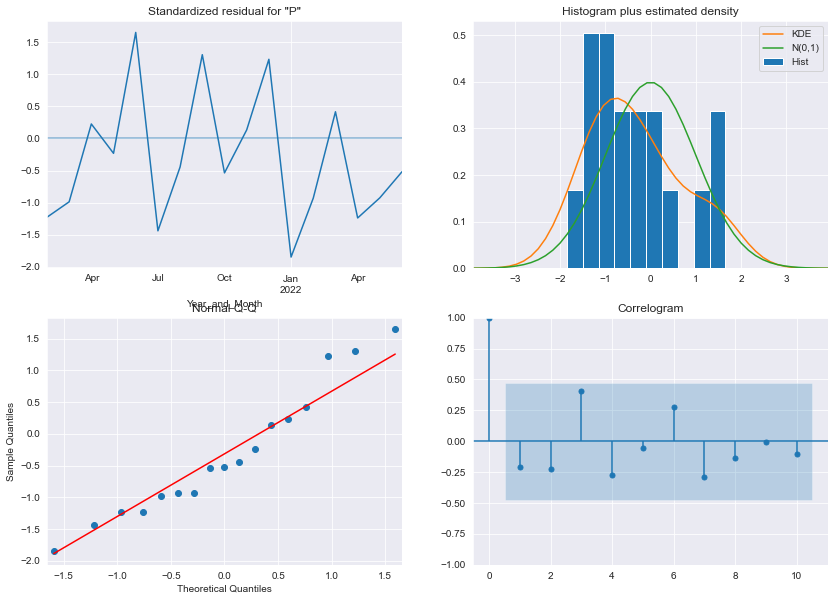

In [70]:
# model summary
model_summary(model)

confirm: This is Transactional Risk (Payments) predictions in 2023


<Figure size 576x432 with 0 Axes>

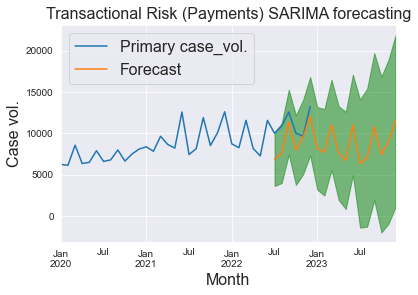

In [71]:
# forecast
forecast = forecast_values(model, tr_pm, 'Transactional Risk', 'Payments')
forecast_plot(model, tr_pm, 'Transactional Risk', 'Payments')

In [72]:
tr_pm_final = final_deliverables(forecast, 'Transactional Risk', 'Payments')
tr_pm_final

,Year_and_Month,Primary case_vol.,Primary_handle_time,Primary_agents_needed,workflow,product
6,2023-01-01,8176.0,114464.0,18,Transactional Risk,Payments
7,2023-02-01,7708.0,107912.0,17,Transactional Risk,Payments
8,2023-03-01,11021.0,154294.0,24,Transactional Risk,Payments
9,2023-04-01,7619.0,106666.0,17,Transactional Risk,Payments
10,2023-05-01,6717.0,94038.0,15,Transactional Risk,Payments
11,2023-06-01,11021.0,154294.0,24,Transactional Risk,Payments
12,2023-07-01,6341.0,88774.0,14,Transactional Risk,Payments
13,2023-08-01,7046.0,98644.0,16,Transactional Risk,Payments
14,2023-09-01,10805.0,151270.0,24,Transactional Risk,Payments
15,2023-10-01,7429.0,104006.0,16,Transactional Risk,Payments


****

# Transactional Risk payroll

confirm: Transactional Risk/Payroll dataframe ready for using


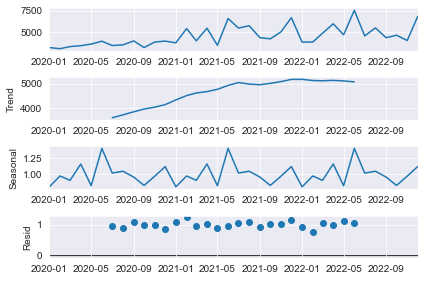

<Figure size 2880x720 with 0 Axes>

ADF Statistic: -4.401494
p-value: 0.000295
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


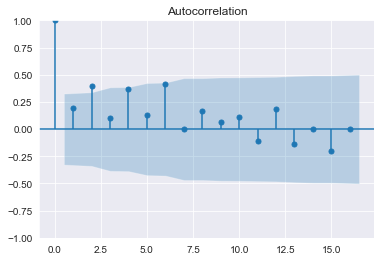

In [73]:
# prepare dataset
tr_pr = data_prep('Transactional Risk', 'Payroll')

# decomposition
decomposition(tr_pr)

# ACF
plot_ACF(tr_pr)

# Dicky_Fuller_test
Dicky_Fuller_test(tr_pr)

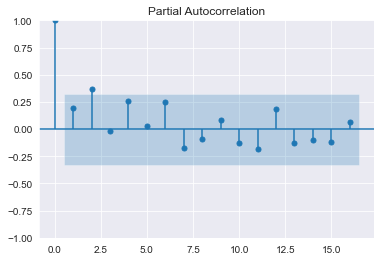

In [74]:
# PACF
plot_PACF(tr_pr)

In [75]:
# split data
train_data, test_data = split_training_and_testing_date(tr_pr)

# Parameter selection
parameter_selection(train_data, 5, 5, 5, 5, 12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=300.672, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=297.942, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=294.070, Time=0.18 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=292.100, Time=0.05 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=294.080, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=293.951, Time=0.12 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=294.014, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=295.965, Time=0.03 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=295.136, Time=0.25 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 1.527 seconds


Mean Absolute Percent Error: 0.248 
conclusion: OK model (0.2 < MAPE <= 0.5)


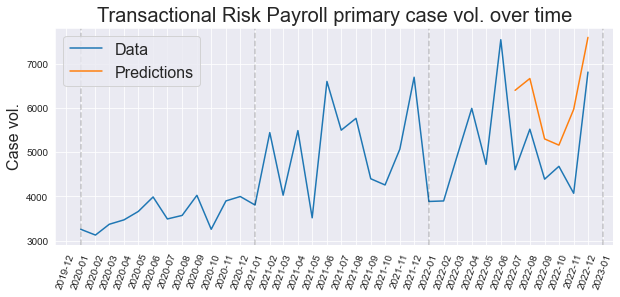

In [76]:
order_lst = [0,1,1]
seasonal_lst = [0,1,0,12]

# fit model
model = fit_model(order_lst, seasonal_lst, train_data)

# model validation
model_validation(test_data, model, tr_pr, 'Transactional Risk', 'Payroll')

                                      SARIMAX Results                                      
Dep. Variable:                   Primary case_vol.   No. Observations:                   30
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -144.050
Date:                             Wed, 01 Mar 2023   AIC                            292.100
Time:                                     07:33:06   BIC                            293.767
Sample:                                 01-01-2020   HQIC                           292.266
                                      - 06-01-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8479      0.366     -2.316      0.021      -1.565      -0.130
sigma2      1.269e+06   4.6

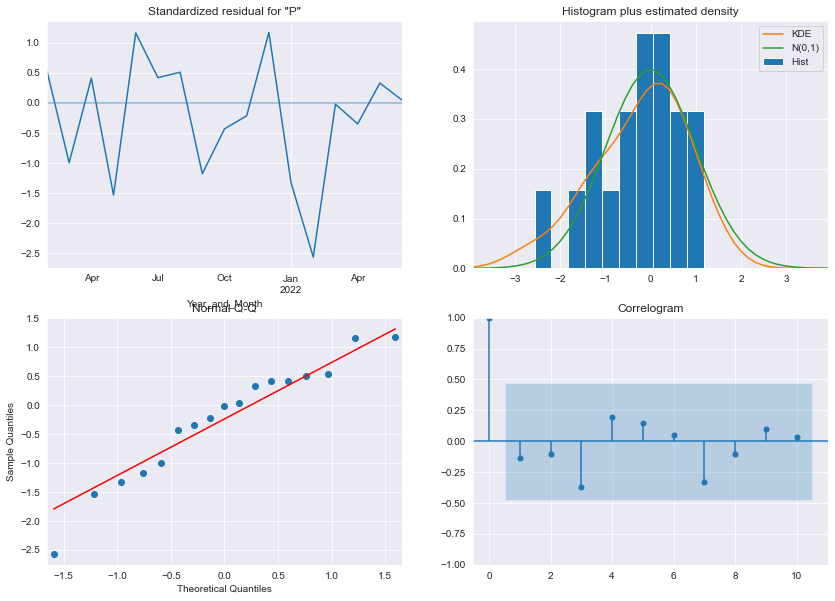

In [77]:
# model summary
model_summary(model)

confirm: This is Transactional Risk (Payroll) predictions in 2023


<Figure size 576x432 with 0 Axes>

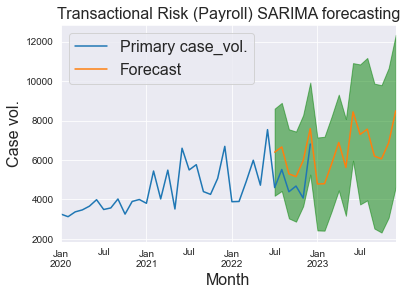

In [78]:
# forecast
forecast = forecast_values(model, tr_pr, 'Transactional Risk', 'Payroll')
forecast_plot(model, tr_pr, 'Transactional Risk', 'Payroll')

In [79]:
tr_pr_final = final_deliverables(forecast, 'Transactional Risk', 'Payroll')
tr_pr_final

,Year_and_Month,Primary case_vol.,Primary_handle_time,Primary_agents_needed,workflow,product
6,2023-01-01,4784.0,40185.6,7,Transactional Risk,Payroll
7,2023-02-01,4796.0,40286.4,7,Transactional Risk,Payroll
8,2023-03-01,5801.0,48728.4,8,Transactional Risk,Payroll
9,2023-04-01,6887.0,57850.8,9,Transactional Risk,Payroll
10,2023-05-01,5622.0,47224.8,8,Transactional Risk,Payroll
11,2023-06-01,8439.0,70887.6,11,Transactional Risk,Payroll
12,2023-07-01,7295.0,61278.0,10,Transactional Risk,Payroll
13,2023-08-01,7562.0,63520.8,10,Transactional Risk,Payroll
14,2023-09-01,6197.0,52054.8,8,Transactional Risk,Payroll
15,2023-10-01,6057.0,50878.8,8,Transactional Risk,Payroll


****

# Chargebacks payments

confirm: Chargebacks/Payments dataframe ready for using


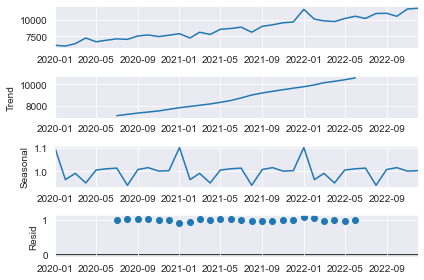

<Figure size 2880x720 with 0 Axes>

ADF Statistic: -0.497187
p-value: 0.892564
Critical Values:
	1%: -3.639
	5%: -2.951
	10%: -2.614
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


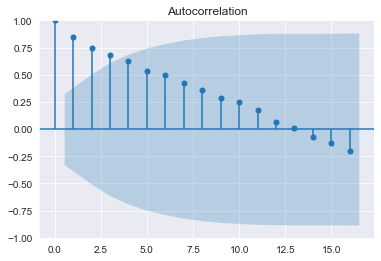

In [80]:
# prepare dataset
ch_pm = data_prep('Chargebacks', 'Payments')

# decomposition
decomposition(ch_pm)

# ACF
plot_ACF(ch_pm)

# Dicky_Fuller_test
Dicky_Fuller_test(ch_pm)

confirm: lag-1 differencing has been taken
ADF Statistic: -9.243235
p-value: 0.000000
Critical Values:
	1%: -3.639
	5%: -2.951
	10%: -2.614
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


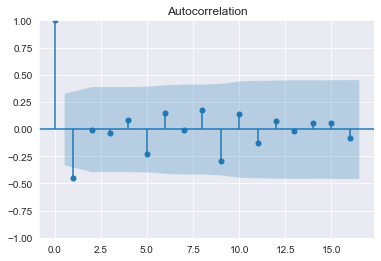

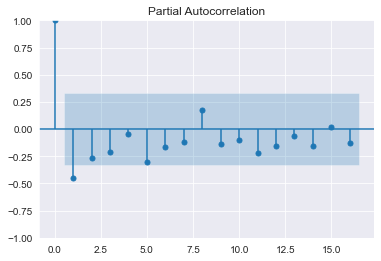

In [81]:
# Take differencing and check stationarity again
ch_pm_diff = differencing(ch_pm, 1)

# ACF
plot_ACF(ch_pm_diff)

# PACF
plot_PACF(ch_pm_diff)

# Dicky_Fuller_test
Dicky_Fuller_test(ch_pm_diff)

In [82]:
# split data
train_data, test_data = split_training_and_testing_date(ch_pm)

# Parameter selection
parameter_selection(train_data, 5, 5, 5, 5, 12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=276.128, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=274.669, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=276.807, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=276.488, Time=0.52 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=276.519, Time=0.50 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.57 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=272.739, Time=0.08 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=274.586, Time=0.28 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=274.603, Time=0.42 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=274.675, Time=0.10 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=

Mean Absolute Percent Error: 0.0406 
conclusion: Very good model (MAPE <= 0.1)


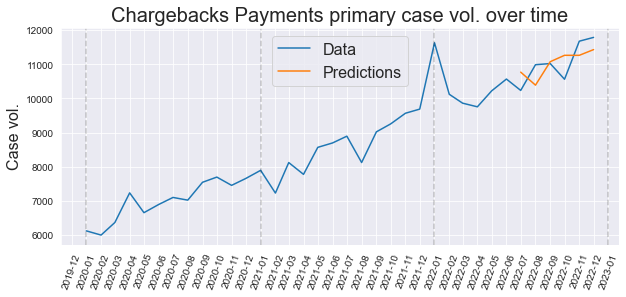

In [83]:
order_lst = [0,1,0]
seasonal_lst = [1,1,0,12]

# fit model
model = fit_model(order_lst, seasonal_lst, train_data)

# model validation
model_validation(test_data, model, ch_pm, 'Chargebacks', 'Payments')

                                     SARIMAX Results                                      
Dep. Variable:                  Primary case_vol.   No. Observations:                   30
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -134.370
Date:                            Wed, 01 Mar 2023   AIC                            272.739
Time:                                    07:33:20   BIC                            274.406
Sample:                                01-01-2020   HQIC                           272.905
                                     - 06-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5638      0.224     -2.515      0.012      -1.003      -0.124
sigma2      4.079e+05   2.16e+05   

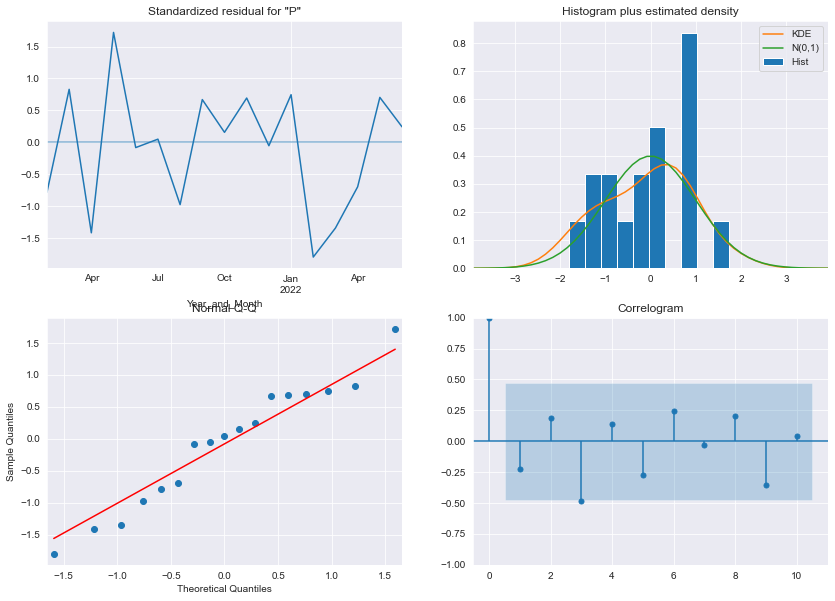

In [84]:
# model summary
model_summary(model)

confirm: This is Chargebacks (Payments) predictions in 2023


<Figure size 576x432 with 0 Axes>

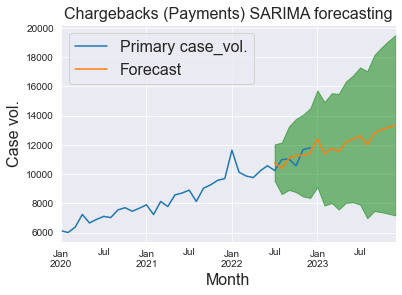

In [85]:
# forecast
forecast = forecast_values(model, ch_pm, 'Chargebacks', 'Payments')
forecast_plot(model, ch_pm, 'Chargebacks', 'Payments')

In [86]:
ch_pm_final = final_deliverables(forecast, 'Chargebacks', 'Payments')
ch_pm_final

,Year_and_Month,Primary case_vol.,Primary_handle_time,Primary_agents_needed,workflow,product
6,2023-01-01,12412.0,62060.0,10,Chargebacks,Payments
7,2023-02-01,11379.0,56895.0,9,Chargebacks,Payments
8,2023-03-01,11769.0,58845.0,9,Chargebacks,Payments
9,2023-04-01,11528.0,57640.0,9,Chargebacks,Payments
10,2023-05-01,12177.0,60885.0,10,Chargebacks,Payments
11,2023-06-01,12401.0,62005.0,10,Chargebacks,Payments
12,2023-07-01,12601.0,63005.0,10,Chargebacks,Payments
13,2023-08-01,12000.0,60000.0,10,Chargebacks,Payments
14,2023-09-01,12806.0,64030.0,10,Chargebacks,Payments
15,2023-10-01,13019.0,65095.0,10,Chargebacks,Payments


****

# Chargebacks payroll

confirm: Chargebacks/Payroll dataframe ready for using


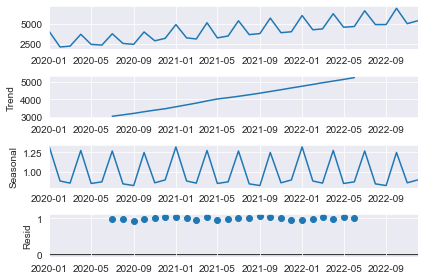

<Figure size 2880x720 with 0 Axes>

ADF Statistic: -0.304758
p-value: 0.924828
Critical Values:
	1%: -3.700
	5%: -2.976
	10%: -2.628
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


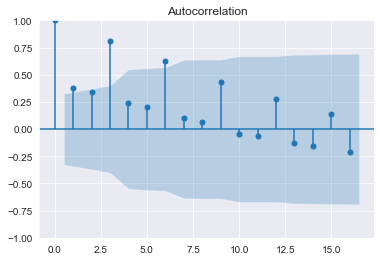

In [87]:
# prepare dataset
ch_pr = data_prep('Chargebacks', 'Payroll')

# decomposition
decomposition(ch_pr)

# ACF
plot_ACF(ch_pr)

# Dicky_Fuller_test
Dicky_Fuller_test(ch_pr)

confirm: lag-1 differencing has been taken
ADF Statistic: -3.746185
p-value: 0.003508
Critical Values:
	1%: -3.738
	5%: -2.992
	10%: -2.636
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


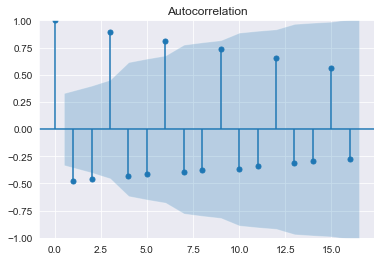

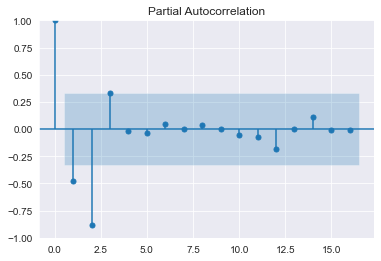

In [88]:
# Take differencing and check stationarity again
ch_pr_diff = differencing(ch_pr, 1)

# ACF
plot_ACF(ch_pr_diff)

# PACF
plot_PACF(ch_pr_diff)

# Dicky_Fuller_test
Dicky_Fuller_test(ch_pr_diff)

In [89]:
# split data
train_data, test_data = split_training_and_testing_date(ch_pr)

# Parameter selection
parameter_selection(train_data, 5, 5, 5, 5, 12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=251.577, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=246.359, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=248.481, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=248.193, Time=1.21 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=253.482, Time=0.10 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=246.788, Time=0.24 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=248.296, Time=0.29 sec

Best model:  ARIMA(1,1,0)(1,1,0)[12]          
Total fit tim

Mean Absolute Percent Error: 0.0688 
conclusion: Very good model (MAPE <= 0.1)


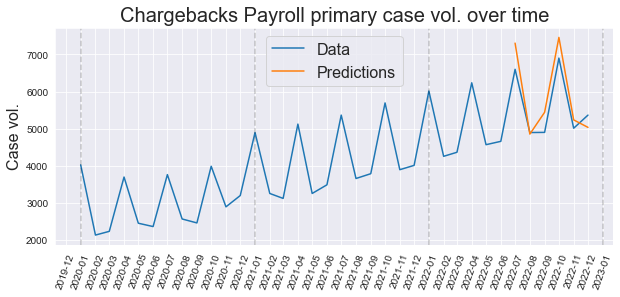

In [90]:
order_lst = [1,1,0]
seasonal_lst = [1,1,0,12]

# fit model
model = fit_model(order_lst, seasonal_lst, train_data)

# model validation
model_validation(test_data, model, ch_pr, 'Chargebacks', 'Payroll')

                                     SARIMAX Results                                      
Dep. Variable:                  Primary case_vol.   No. Observations:                   30
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -120.180
Date:                            Wed, 01 Mar 2023   AIC                            246.359
Time:                                    07:33:33   BIC                            248.859
Sample:                                01-01-2020   HQIC                           246.608
                                     - 06-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8467      0.186     -4.556      0.000      -1.211      -0.482
ar.S.L12       0.8610      0.292   

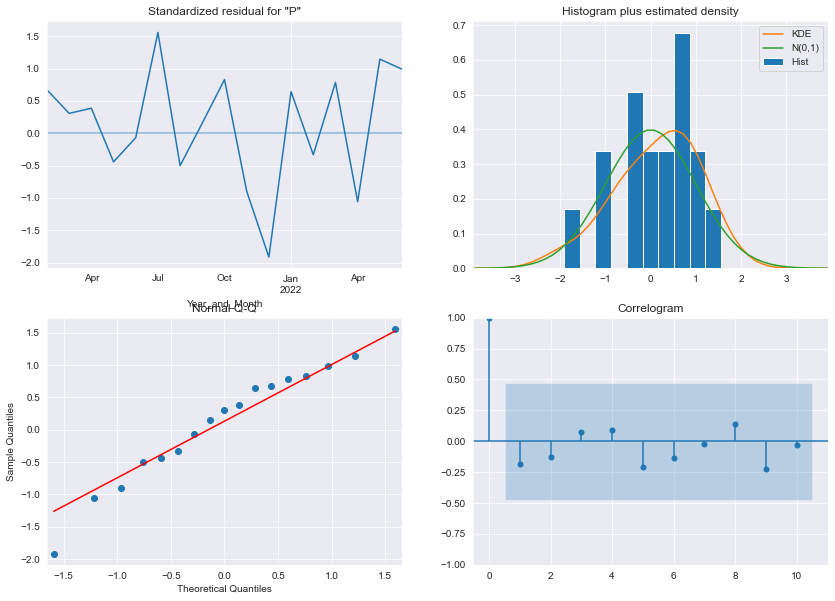

In [91]:
# model summary
model_summary(model)

confirm: This is Chargebacks (Payroll) predictions in 2023


<Figure size 576x432 with 0 Axes>

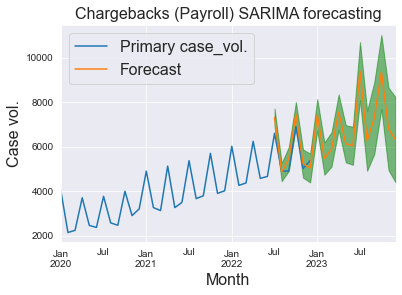

In [92]:
# forecast
forecast = forecast_values(model, ch_pr, 'Chargebacks', 'Payroll')
forecast_plot(model, ch_pr, 'Chargebacks', 'Payroll')

In [93]:
ch_pr_final = final_deliverables(forecast, 'Chargebacks', 'Payroll')
ch_pr_final

,Year_and_Month,Primary case_vol.,Primary_handle_time,Primary_agents_needed,workflow,product
6,2023-01-01,7430.0,22290.0,4,Chargebacks,Payroll
7,2023-02-01,5461.0,16383.0,3,Chargebacks,Payroll
8,2023-03-01,5873.0,17619.0,3,Chargebacks,Payroll
9,2023-04-01,7551.0,22653.0,4,Chargebacks,Payroll
10,2023-05-01,6126.0,18378.0,3,Chargebacks,Payroll
11,2023-06-01,6035.0,18105.0,3,Chargebacks,Payroll
12,2023-07-01,9389.0,28167.0,5,Chargebacks,Payroll
13,2023-08-01,6260.0,18780.0,3,Chargebacks,Payroll
14,2023-09-01,7276.0,21828.0,4,Chargebacks,Payroll
15,2023-10-01,9358.0,28074.0,5,Chargebacks,Payroll


****

# Collections payments

confirm: Collections/Payments dataframe ready for using


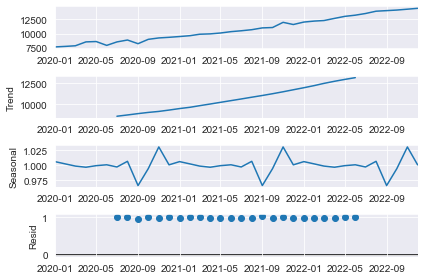

<Figure size 2880x720 with 0 Axes>

ADF Statistic: 0.487207
p-value: 0.984479
Critical Values:
	1%: -3.639
	5%: -2.951
	10%: -2.614
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


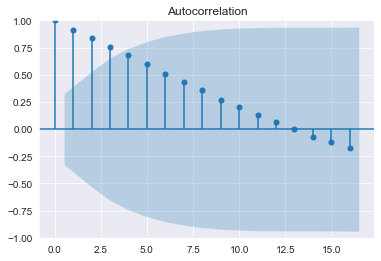

In [94]:
# prepare dataset
co_pm = data_prep('Collections', 'Payments')

# decomposition
decomposition(co_pm)

# ACF
plot_ACF(co_pm)

# Dicky_Fuller_test
Dicky_Fuller_test(co_pm)

confirm: lag-1 differencing has been taken
ADF Statistic: -9.110519
p-value: 0.000000
Critical Values:
	1%: -3.639
	5%: -2.951
	10%: -2.614
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


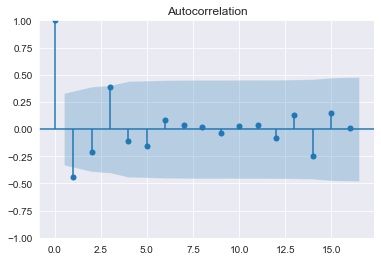

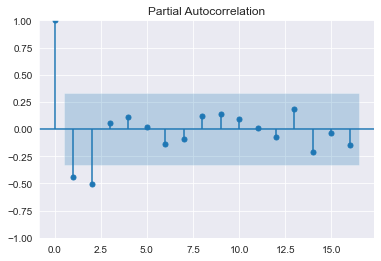

In [95]:
# Take differencing and check stationarity again
co_pm_diff = differencing(co_pm, 1)

# ACF
plot_ACF(co_pm_diff)

# PACF
plot_PACF(co_pm_diff)

# Dicky_Fuller_test
Dicky_Fuller_test(co_pm_diff)

In [96]:
# split data
train_data, test_data = split_training_and_testing_date(co_pm)

# Parameter selection
parameter_selection(train_data, 5, 5, 5, 5, 12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=259.411, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=256.635, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=255.526, Time=0.20 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=255.281, Time=0.08 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=255.603, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=256.759, Time=0.08 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=256.372, Time=0.07 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 1.631 seconds


Mean Absolute Percent Error: 0.0198 
conclusion: Very good model (MAPE <= 0.1)


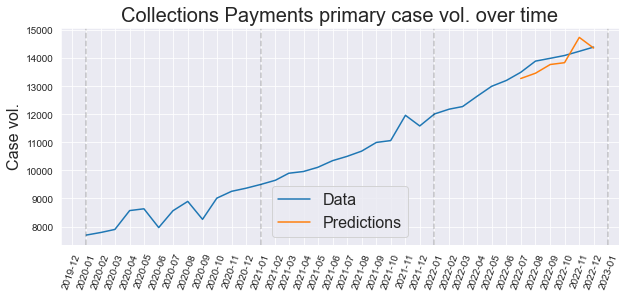

In [97]:
order_lst = [0,1,1]
seasonal_lst = [0,1,0,12]

# fit model
model = fit_model(order_lst, seasonal_lst, train_data)

# model validation
model_validation(test_data, model, co_pm, 'Collections', 'Payments')

                                      SARIMAX Results                                      
Dep. Variable:                   Primary case_vol.   No. Observations:                   30
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -125.640
Date:                             Wed, 01 Mar 2023   AIC                            255.281
Time:                                     07:33:43   BIC                            256.947
Sample:                                 01-01-2020   HQIC                           255.447
                                      - 06-01-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5368      0.240     -2.235      0.025      -1.007      -0.066
sigma2      1.352e+05   4.4

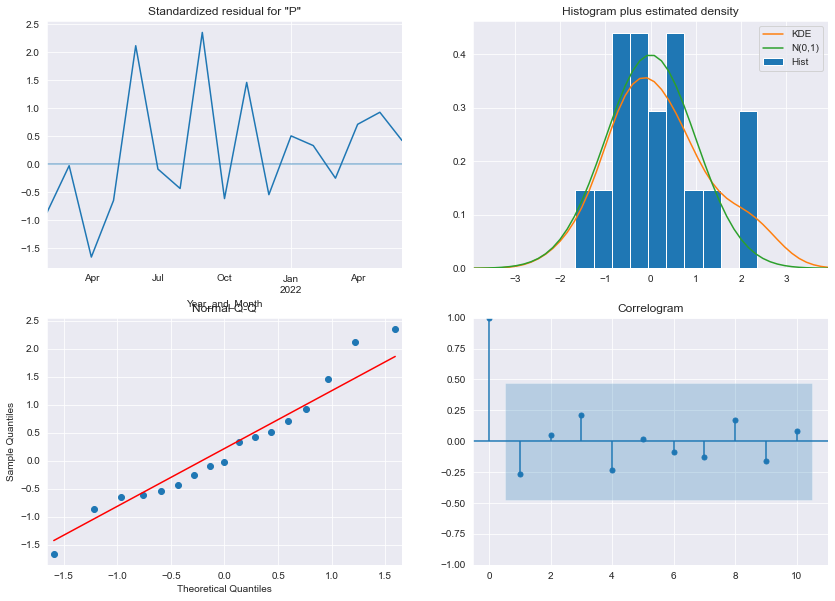

In [98]:
# model summary
model_summary(model)

confirm: This is Collections (Payments) predictions in 2023


<Figure size 576x432 with 0 Axes>

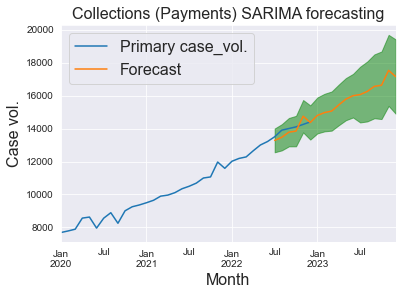

In [99]:
# forecast
forecast = forecast_values(model, co_pm, 'Collections', 'Payments')
forecast_plot(model, co_pm, 'Collections', 'Payments')

In [100]:
co_pm_final = final_deliverables(forecast, 'Collections', 'Payments')
co_pm_final

,Year_and_Month,Primary case_vol.,Primary_handle_time,Primary_agents_needed,workflow,product
6,2023-01-01,14794.0,78260.26,12,Collections,Payments
7,2023-02-01,14966.0,79170.14,13,Collections,Payments
8,2023-03-01,15058.0,79656.82,13,Collections,Payments
9,2023-04-01,15432.0,81635.28,13,Collections,Payments
10,2023-05-01,15781.0,83481.49,13,Collections,Payments
11,2023-06-01,15990.0,84587.10,13,Collections,Payments
12,2023-07-01,16058.0,84946.82,13,Collections,Payments
13,2023-08-01,16247.0,85946.63,14,Collections,Payments
14,2023-09-01,16558.0,87591.82,14,Collections,Payments
15,2023-10-01,16623.0,87935.67,14,Collections,Payments


****

# Collections payroll

confirm: Collections/Payroll dataframe ready for using


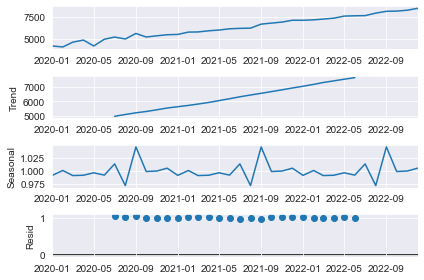

<Figure size 2880x720 with 0 Axes>

ADF Statistic: 0.981422
p-value: 0.994066
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


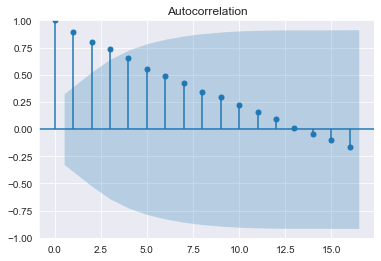

In [101]:
# prepare dataset
co_pr = data_prep('Collections', 'Payroll')

# decomposition
decomposition(co_pr)

# ACF
plot_ACF(co_pr)

# Dicky_Fuller_test
Dicky_Fuller_test(co_pr)

confirm: lag-1 differencing has been taken
ADF Statistic: -9.853558
p-value: 0.000000
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


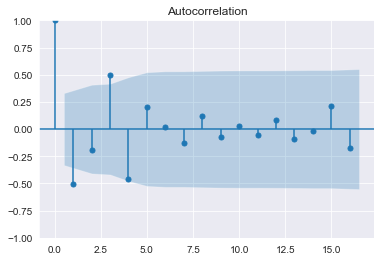

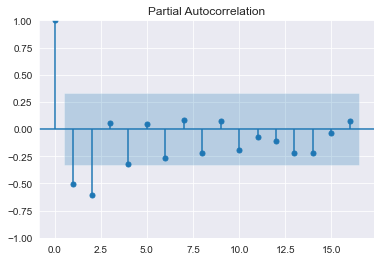

In [102]:
# Take differencing and check stationarity again
co_pr_diff = differencing(co_pr, 1)

# ACF
plot_ACF(co_pr_diff)

# PACF
plot_PACF(co_pr_diff)

# Dicky_Fuller_test
Dicky_Fuller_test(co_pr_diff)

In [103]:
# split data
train_data, test_data = split_training_and_testing_date(co_pr)

# Parameter selection
parameter_selection(train_data, 5, 5, 5, 5, 12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=247.133, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=246.744, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=243.093, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=241.093, Time=0.04 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=243.093, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=244.774, Time=0.04 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 1.492 seconds


Mean Absolute Percent Error: 0.011 
conclusion: Very good model (MAPE <= 0.1)


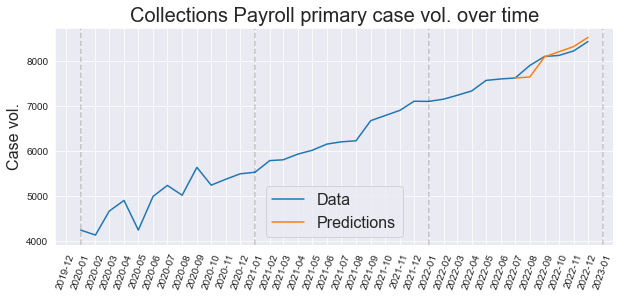

In [104]:
order_lst = [0,1,1]
seasonal_lst = [0,1,0,12]

# fit model
model = fit_model(order_lst, seasonal_lst, train_data)

# model validation
model_validation(test_data, model, co_pr, 'Collections', 'Payroll')

                                      SARIMAX Results                                      
Dep. Variable:                   Primary case_vol.   No. Observations:                   30
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -118.547
Date:                             Wed, 01 Mar 2023   AIC                            241.093
Time:                                     07:33:50   BIC                            242.760
Sample:                                 01-01-2020   HQIC                           241.259
                                      - 06-01-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8775      0.359     -2.442      0.015      -1.582      -0.173
sigma2      5.948e+04    3.

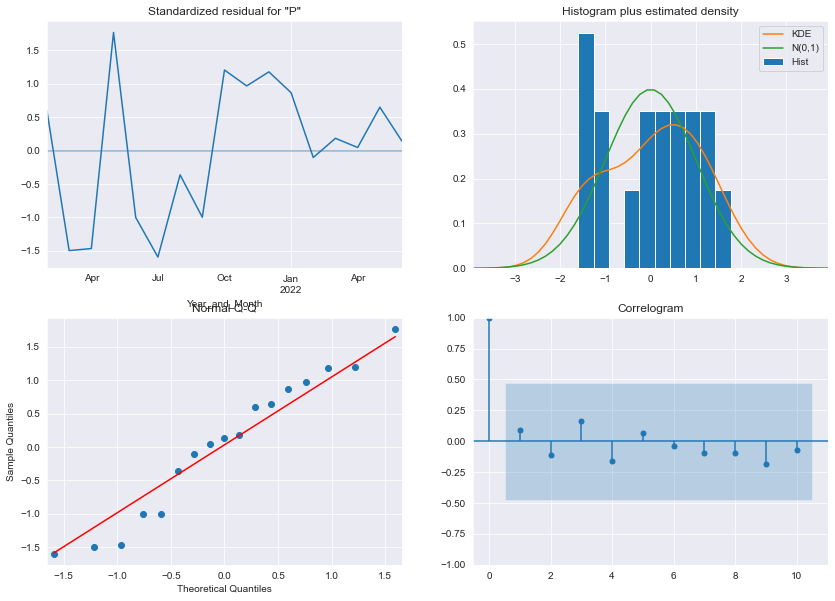

In [105]:
# model summary
model_summary(model)

confirm: This is Collections (Payroll) predictions in 2023


<Figure size 576x432 with 0 Axes>

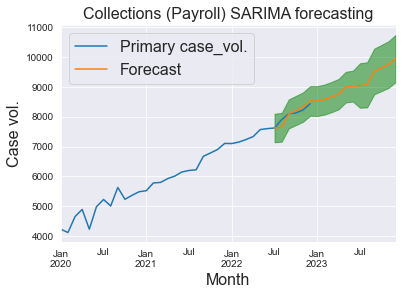

In [106]:
# forecast
forecast = forecast_values(model, co_pr, 'Collections', 'Payroll')
forecast_plot(model, co_pr, 'Collections', 'Payroll')

In [107]:
co_pr_final = final_deliverables(forecast, 'Collections', 'Payroll')
co_pr_final

,Year_and_Month,Primary case_vol.,Primary_handle_time,Primary_agents_needed,workflow,product
6,2023-01-01,8520.0,27042.480,5,Collections,Payroll
7,2023-02-01,8570.0,27201.180,5,Collections,Payroll
8,2023-03-01,8654.0,27467.796,5,Collections,Payroll
9,2023-04-01,8753.0,27782.022,5,Collections,Payroll
10,2023-05-01,8987.0,28524.738,5,Collections,Payroll
11,2023-06-01,9020.0,28629.480,5,Collections,Payroll
12,2023-07-01,9041.0,28696.134,5,Collections,Payroll
13,2023-08-01,9064.0,28769.136,5,Collections,Payroll
14,2023-09-01,9513.0,30194.262,5,Collections,Payroll
15,2023-10-01,9625.0,30549.750,5,Collections,Payroll


****

# Final deliverables

In [108]:
frames = [un_pm_final, un_pr_final, fr_pm_final, fr_pr_final, tr_pm_final, 
          tr_pr_final, ch_pm_final, ch_pr_final, co_pm_final, co_pr_final]

df_final = pd.concat(frames).reset_index().drop(['index'], axis=1)

In [109]:
df_final.head()

,Year_and_Month,Primary case_vol.,Follow-up case_vol.,Primary_handle_time,Primary_agents_needed,Follow-up_handle_time,Follow-up_agents_needed,workflow,product
0,2023-01-01,8372.0,1256.0,100464.0,16,10048.0,2.0,Underwriting,Payments
1,2023-02-01,6039.0,906.0,72468.0,12,7248.0,2.0,Underwriting,Payments
2,2023-03-01,6172.0,926.0,74064.0,12,7408.0,2.0,Underwriting,Payments
3,2023-04-01,6501.0,975.0,78012.0,12,7800.0,2.0,Underwriting,Payments
4,2023-05-01,5699.0,855.0,68388.0,11,6840.0,2.0,Underwriting,Payments


In [110]:
# df_final.to_csv('agents_needed.csv', index=False) 